In [1]:
FN = 'vocab'

In [2]:
seed = 42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [5]:
lower = False

In [6]:
import pickle
import json
import jsonlines
import pandas as pd

In [7]:
FN0 = 'sample-1M'

In [8]:
with jsonlines.open('data/sample-1M.jsonl', 'r') as fp:
    content = fp.read()

In [9]:
content.keys()

[u'title', u'media-type', u'content', u'source', u'published', u'id']

In [10]:
df = pd.read_json('data/sample-1M.jsonl', lines=True)

In [11]:
# toy = df.head(684114)
toy = df.head(10000)

In [12]:
desc = toy['content']
heads = toy['title']

In [13]:
if lower:
    desc = [h.lower() for h in toy['content']]

In [14]:
if lower:
    heads = [h.lower() for h in toy['title']]

In [15]:
i=0
heads[i]

u'Worcester breakfast club for veterans gives hunger its marching orders'

In [16]:
desc[i]

u'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. \n \nThe Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday. \n \nThe club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. \n \nFather-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country. \n \nHe said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up. \n \n"We even had an old chap travel from Droitwich and he was late on parade by three hours. \n \n"It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards." \n \nHe said the management at the pub h

In [17]:
len(heads), len(set(heads))

(10000, 9941)

In [18]:
len(desc), len(set(desc))

(10000, 9899)

In [19]:
from collections import Counter
from itertools import chain

def get_vocab(arr):
    vocab_count = Counter(w for txt in arr for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocab_count.items(), key=lambda x: -x[1]))
    return list(vocab), vocab_count

In [20]:
vocab, vocab_count = get_vocab(heads+desc)

Text(0,0.5,u'total appearances')

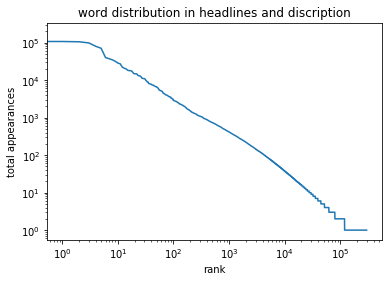

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocab_count[w] for w in vocab])
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances')

In [22]:
empty = 0
eos = 1
start_idx = eos + 1

In [23]:
def get_idx(vocab, vocab_count):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [24]:
word2idx, idx2word = get_idx(vocab, vocab_count)

In [25]:
import os
fname = 'glove.6B.%dd.txt'%embedding_dim
datadir = "glove"
glove_name = os.path.join(datadir, fname)
print(glove_name)
print(os.path.exists(glove_name))

glove\glove.6B.100d.txt
True


In [31]:
glove_n_symbols = 400000
# glove_n_symbols = 4000

In [32]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
# with open(glove_name, 'r', encoding='utf8') as fp:
with open(glove_name, 'r') as fp:    
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [33]:
glove_embedding_weights.std()

0.040815727600190289

In [34]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [35]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

('random-embedding/glove scale', 0.070694913951420899, 'std', 0.040813824957463822)
('number of tokens, in small vocab, found in glove and copied to embedding', 27159, 0.678975)


In [36]:
glove_thr = 0.5

In [37]:
word2glove = {}
for w in word2idx:
#     w = w.decode('latin1')
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

C:\Users\risha\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:4: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  after removing the cwd from sys.path.
C:\Users\risha\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:6: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  


In [38]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100
# nb_unknown_words = 40

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        if len(score) != 0:
            while True:
                embedding_idx = score.argmax()
                s = score[embedding_idx]
                if s < glove_thr:
                    break
                if idx2word[embedding_idx] in word2glove :
                    glove_match.append((w, embedding_idx, s)) 
                    break
                score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

('# of glove substitutes found', 47685)


In [39]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

(0.50004907387522568, u'bails', '=>', u'wipes')
(0.50004802356620304, u'Motherfucker', '=>', u'fucking')
(0.50004699097115313, u'chiming', '=>', u'bells')
(0.50003436280374836, u'potshot', '=>', u'Dianabol')
(0.50003012935289903, u'grout', '=>', u'stain')
(0.50002648825037499, u'Biz', '=>', u'showbiz')
(0.50002648825037499, u'biz', '=>', u'showbiz')
(0.50001919069480794, u'codefendant', '=>', u'55-year-old')
(0.50000463576479592, u'Ridgeway', '=>', u'Stoney')
(0.50000181969956181, u'perpetuities', '=>', u'D-Link')


In [40]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

In [41]:
Y = []
for headline in heads:
    temp = []
    for token in headline.split():
        if token in word2idx:
            temp.append(word2idx[token])
    Y.append(temp)
len(Y)

10000

(array([  1.90000000e+01,   6.50000000e+01,   1.95000000e+02,
          2.64000000e+02,   4.05000000e+02,   6.38000000e+02,
          8.52000000e+02,   9.77000000e+02,   1.15700000e+03,
          1.20100000e+03,   1.03000000e+03,   8.31000000e+02,
          6.24000000e+02,   4.46000000e+02,   3.29000000e+02,
          2.19000000e+02,   0.00000000e+00,   1.98000000e+02,
          1.54000000e+02,   1.11000000e+02,   6.10000000e+01,
          4.50000000e+01,   2.50000000e+01,   2.80000000e+01,
          2.70000000e+01,   1.60000000e+01,   1.70000000e+01,
          7.00000000e+00,   6.00000000e+00,   7.00000000e+00,
          8.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   1.00000000e+00,
        

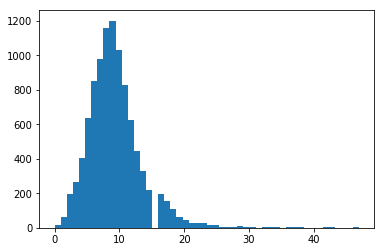

In [42]:
plt.hist(map(len,list(Y)),bins=50)
# plt.hist(Y)

In [43]:
X = []
for d in desc:
    temp = []
    for token in d.split():
        if token in word2idx:
            temp.append(word2idx[token])
    X.append(temp)
len(X)

10000

KeyboardInterrupt: 

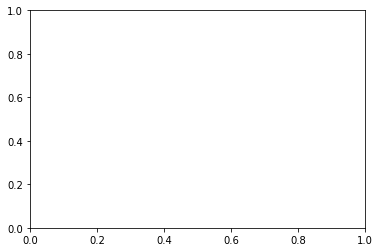

In [44]:
plt.hist(X)

In [45]:
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [46]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)